# Аналитика в Яндекс.Афише

### Помочь оптимизировать маркетинговые затраты

#### Таблица visits (лог сервера с информацией о посещениях сайта):

Uid — уникальный идентификатор пользователя

Device — категория устройства пользователя

Start Ts — дата и время начала сессии

End Ts — дата и время окончания сессии

Source Id — идентификатор рекламного источника, из которого пришел пользователь

#### Таблица orders (информация о заказах):
    
Uid — уникальный id пользователя, который сделал заказ

Buy Ts — дата и время заказа

Revenue — выручка Яндекс.Афиши с этого заказа

#### Таблица costs (информация о затратах на маркетинг):
    
source_id — идентификатор рекламного источника

dt — дата

costs — затраты на этот рекламный источник в этот день

У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая. Лог сервера с данными о посещениях сайта Яндекс.Афиши,выгрузка всех заказов за этот период,статистика рекламных расходов.

In [1]:
#conda install -c plotly plotly==4.0.0

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats as st


In [3]:
#import datetime
#from datetime import date
#import pandas as pd
#import numpy as np
#from plotly import __version__
#%matplotlib inline

#import plotly.offline as pyo
#import plotly.graph_objs as go
#from plotly.offline import iplot

#import cufflinks as cf
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
#init_notebook_mode(connected=True)

#cf.go_offline()

Загрузим и изучим данные таблицы <b>visits</b>


In [4]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [5]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Столбцы "End Ts" и "Start Ts"	имеют тип данных object. Поменяем его.


In [7]:
visits = visits.rename(columns={'End Ts': 'session_end', 'Start Ts': 'session_start'})
visits.columns = visits.columns.str.lower() #переведем все названия таблицы в нижний регистр 

In [8]:
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

In [9]:
visits.isnull().sum()

device           0
session_end      0
source id        0
session_start    0
uid              0
dtype: int64

In [10]:
visits.head(5)

,device,session_end,source id,session_start,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Изменены названия столбцов 'End Ts' на 'session_end', 'Start Ts' на 'session_start'
Поменяли тип данных в столбцах "session_end" и "session_start" на datetime. Пропущенных значений нет. Перевели названия столбцов в нижний регистр. Можно работать с этой таблицей

Загрузим и изучим данные таблицы <b>orders</b>


In [11]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [12]:
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [14]:
orders = orders.rename(columns={'Buy Ts': 'date_of_purchase'})
orders.columns = orders.columns.str.lower()

In [15]:
orders['date_of_purchase'] = pd.to_datetime(orders['date_of_purchase'])

In [16]:
orders.isnull().sum()

date_of_purchase    0
revenue             0
uid                 0
dtype: int64

In [17]:
orders.head(5)

,date_of_purchase,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Изменено названия столбца "Buy Ts" на "date_of_purchase" Поменяли тип данных в "date_of_purchase" на datetime. Перевели навзания столбцов в нижний регистр. Пропущенных значений нет. Можно работать с этой таблицей

Загрузим и изучим данные таблицы <b>costs</b>


In [18]:
costs = pd.read_csv('/datasets/costs.csv')

In [19]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [20]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [21]:
costs = costs.rename(columns={'dt': 'date'})
costs.columns = costs.columns.str.lower()

In [22]:
costs['date'] = pd.to_datetime(costs['date'], format='%Y-%m-%d')

In [23]:
costs.isnull().sum()

source_id    0
date         0
costs        0
dtype: int64

In [24]:
costs.head(5)

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Изменено названия столбца 'dt' на 'date'. Поменяли тип данных в 'date' на datetime. Перевели навзания столбцов в нижний регистр. Пропущенных значений нет. Можно работать с этой таблицей

## Изучим продукт. Изучим внимательнее таблицу visits. 
    
Сколько людей пользуются в день, неделю, месяц?
    
Сколько сессий в день?
    
Сколько длится одна сессия?
    
Как часто люди возвращаются? 

In [25]:
import decimal

In [26]:
#Подготовим данные: выделим день, неделю, месяц, а так же узнаем длительность сессии. 
#Все это вынесем в отдельные столбцы таблицы. 
visits['session_data'] = visits['session_start'].dt.date
visits['session_week'] = visits['session_start'].dt.week
visits['session_month'] = visits['session_start'].dt.to_period('M')
visits['session_duration'] = visits['session_end'] - visits['session_start']
visits['session_duration'] = visits['session_duration'].apply(lambda x: decimal.Decimal(x.seconds) // 60)
visits['session_duration'] = visits['session_duration'].astype('int')

In [27]:
visits.head(10)

,device,session_end,source id,session_start,uid,session_data,session_week,session_month,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,2017-12,18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2018-02,28
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,2017-07,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,2018-05,24
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,2017-12,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,35,2017-09,1
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,5,2018-01,56
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-05,44,2017-11,1
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-19,29,2017-07,3
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-08,45,2017-11,1


In [28]:
#количество уникальных пользователей, зашедших в приложение хотя бы раз в течение суток
visits_DAU = visits.groupby('session_data')['uid'].nunique().reset_index()
visits_DAU = visits_DAU.rename(columns={'uid': 'uid_DAU'})
#количество пользователей, зашедших в приложение в день
visits_count_day = visits.groupby('session_data')['uid'].count().reset_index()
visits_count_day = visits_count_day.rename(columns={'uid': 'uid_count_day'})

Посмотрим, сколько раз пользователи заходили в приложение в каждый из дней.

In [29]:
visits_DAU_and_count_day = visits_DAU.merge(visits_count_day, on='session_data', how='inner')

In [30]:
#visits_DAU_and_count_day.iplot(kind='line',x='session_data',y=['uid_DAU', 'uid_count_day'], color=['white', 'gold'], theme='solar', mode='lines',title='Кол-во пользователей и кол-во уникальных пользователей в день')

In [31]:
visits_DAU_and_count_day.head(5)

,session_data,uid_DAU,uid_count_day
0,2017-06-01,605,664
1,2017-06-02,608,658
2,2017-06-03,445,477
3,2017-06-04,476,510
4,2017-06-05,820,893


In [32]:
(visits_DAU_and_count_day.style
                .bar(subset=['uid_DAU', 'uid_count_day'], color='#B0E0E6', vmin=0, width=100)
                .set_caption('Количество пользователей и  уникальных пользователей, зашедших в приложение за день')
)

,session_data,uid_DAU,uid_count_day
0,2017-06-01,605,664
1,2017-06-02,608,658
2,2017-06-03,445,477
3,2017-06-04,476,510
4,2017-06-05,820,893
5,2017-06-06,797,875
6,2017-06-07,699,788
7,2017-06-08,868,939
8,2017-06-09,695,755
9,2017-06-10,350,375


In [33]:
visits_DAU_and_count_day['uid_DAU'].mean().round() #среднее кол-во уникальных посетителей в день

908.0

In [34]:
visits_DAU_and_count_day['uid_count_day'].mean().round() #среднее кол-во сессий в день

987.0

среднее кол-во уникальных посетителей в день: 908.0
    
среднее кол-во посетителей сессий в день  987.0

Посмотрим по неделям

In [35]:
#количество уникальных пользователей в неделю 
visits_WAU = visits.groupby('session_week')['uid'].nunique().reset_index()
visits_WAU = visits_WAU.rename(columns={'uid': 'uid_WAU'})
#количество пользователей, зашедших в приложение в неделю
visits_count_week = visits.groupby('session_week')['uid'].count().reset_index()
visits_count_week = visits_count_week.rename(columns={'uid': 'uid_count_week'})

In [36]:
visits_WAU_and_count_week = visits_WAU.merge(visits_count_week, on='session_week', how='inner')

In [37]:
#visits_WAU_and_count_week.iplot(kind='line',x='session_week',y=['uid_WAU', 'uid_count_week'], color=['white', 'gold'], theme='solar', mode='lines',title='Кол-во пользователей и кол-во уникальных пользователей в неделю')

In [38]:
(visits_WAU_and_count_week.style
                       .bar(subset=['uid_count_week', 'uid_WAU'], color='#B0E0E6', vmin=0, width=100)
                       .set_caption("Количество пользователей, зашедших в приложение в неделю")
)

,session_week,uid_WAU,uid_count_week
0,1,6918,8057
1,2,6703,7871
2,3,6972,8317
3,4,7060,8488
4,5,8111,9796
5,6,7908,9407
6,7,7759,9272
7,8,7518,8930
8,9,7395,8771
9,10,6844,8147


In [39]:
visits_WAU_and_count_week['uid_WAU'].mean().round() #среднее кол-во уникальных посетителей в неделю

5825.0

In [40]:
visits_WAU_and_count_week['uid_count_week'].mean().round() #среднее кол-во сессий в неделю

6912.0

среднее кол-во уникальных посетителей в неделю 5825.0

среднее кол-во сессий в неделю 6912.0

Посмотрим по месяцам 

In [41]:
#количество уникальных пользователей в месяц
visits_MAU = visits.groupby('session_month')['uid'].nunique().reset_index()
visits_MAU = visits_MAU.rename(columns={'uid': 'uid_MAU'})
#количество пользователей, зашедших в приложение в месяц
visits_count_month = visits.groupby('session_month')['uid'].count().reset_index()
visits_count_month = visits_count_month.rename(columns={'uid': 'uid_count_month'})

In [42]:
visits_MAU_and_count_month = visits_MAU.merge(visits_count_month, on='session_month', how='inner')

In [43]:
#visits_MAU_and_count_month.iplot(kind='line',x='session_month',y=['uid_MAU', 'uid_count_month'], color=['white', 'gold'], 
#theme='solar', mode='lines',title='Кол-во пользователей и кол-во уникальных пользователей в месяц')


In [44]:
(visits_MAU_and_count_month.style
                       .bar(subset=['uid_count_month', 'uid_MAU'], color='#B0E0E6', vmin=0, width=100)
                       .set_caption("Количество пользователей, зашедших в приложение в месяц")
)

,session_month,uid_MAU,uid_count_month
0,2017-06,13259,16505
1,2017-07,14183,17828
2,2017-08,11631,14355
3,2017-09,18975,23907
4,2017-10,29692,37903
5,2017-11,32797,43969
6,2017-12,31557,41983
7,2018-01,28716,36939
8,2018-02,28749,37182
9,2018-03,27473,35679


In [45]:
visits_MAU_and_count_month['uid_MAU'].mean().round()  #среднее кол-во уникальных посетителей в месяц

23228.0

In [46]:
visits_MAU_and_count_month['uid_count_month'].mean().round() #среднее кол-во сессий в месяц

29950.0

среднее кол-во уникальных посетителей в месяц 23228.0

среднее кол-во сессий в месяц 29950.0



(0, 100)

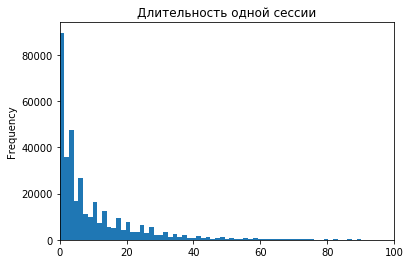

In [47]:

visits['session_duration'].plot(kind='hist',bins = 1000,
                   title='Длительность одной сессии')
plt.xlim(0,100)

In [48]:
visits['session_duration'].mean()

10.724343350027825

In [49]:
visits['session_duration'].median()

5.0

retention

In [50]:
first_activity_date = visits.groupby('uid')['session_start'].min()
first_activity_date.name = 'first_session_month'
retention = visits.join(first_activity_date,on='uid')
retention['first_session_month'] = retention['first_session_month'].astype('datetime64[M]')
retention['session_month'] = retention['session_start'].astype('datetime64[M]')
retention['cohort_lifetime'] = retention['session_month'] - retention['first_session_month']
retention['cohort_lifetime'] = retention['cohort_lifetime'] / np.timedelta64(1,'M')
retention['cohort_lifetime'] = retention['cohort_lifetime'].round().astype('int')
cohorts = (retention
                           .groupby(['first_session_month', 'cohort_lifetime'])
                           .agg({'uid': 'nunique'})
                           .reset_index())


In [51]:
cohorts

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [52]:
initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_session_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'})

cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                          values='retention', aggfunc='sum')




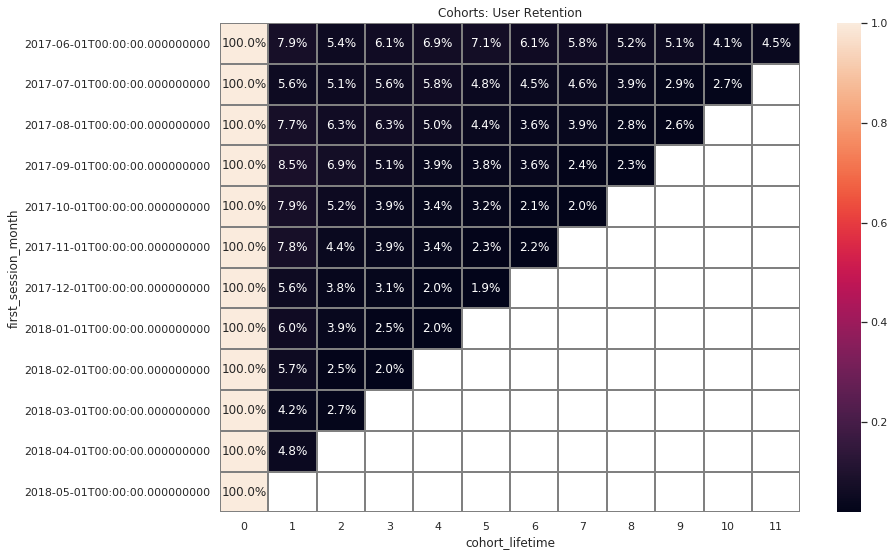

In [53]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

<b>Сколько людей пользуются продуктом в день, неделю, месяц?</b>

<b>DAU:</b> 908 пользователей
<b>MAU:</b> 5825 пользователя
<b>WAU:</b> 23228 пользователей

<b>Сколько сессий в день?</b>

987 сессий. Можно сделать вывод, что пользователи в среднем заходят только раз в день.

<b>мСколько длится одна сессия?</b>

Продолдительность сесси от 0 до 2 минут. Значит пользователи долго на сайте не задерживаются, а почти сразу с него уходят.

<b>Как часто люди возвращаются?</b>

Retention не высокий. На второй месяц 5,5%-8,5%, но дальше он падает до 2,5%-3,5%. Стоить отметить что самый стойкий Retention у первой когорты. Все кто пришли после не так часто возвращаются по сравнению с ними. 

##  Ознакомимся с продажами
    
Когда люди начинают покупать?
    
Сколько раз покупают за период?
    
Какой средний чек?
    
Сколько денег приносят? (LTV)


Сгруппируем два датафрейма visits и orders. Нам нужны столбцы дата первого заказа и дата визита. 

In [54]:
first_purchase_date = orders.groupby('uid')[['date_of_purchase']].min().reset_index()
first_purchase_date.columns = ['uid', 'first_purchase_date']
first_session_date = visits.groupby('uid')[['session_start']].min().reset_index()
first_session_date.columns = ['uid', 'first_session']

In [55]:
visits_and_orders = first_purchase_date.merge(first_session_date, on='uid') #соединим два датафрейма вместе

In [56]:
visits_and_orders.head()

,uid,first_purchase_date,first_session
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


## Когда начинают покупать? 

Узнаем, была ли покупка, и если была, то через сколько, после того, как пользователь посетил сайт

In [57]:
visits_and_orders['buy_diff'] = visits_and_orders['first_purchase_date'] - visits_and_orders['first_session']
visits_and_orders['buy_diff'] = visits_and_orders['buy_diff']/np.timedelta64(1, 'm')
visits_and_orders['buy_diff'] = visits_and_orders['buy_diff'].round(1)
visits_and_orders.head(10)

,uid,first_purchase_date,first_session,buy_diff
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0
5,3077748354309989,2018-03-03 12:33:00,2018-03-03 12:08:00,25.0
6,3605148382144603,2017-09-21 20:56:00,2017-08-15 21:54:00,53222.0
7,3753586865891862,2018-03-03 13:50:00,2018-03-03 13:47:00,3.0
8,4808417689019433,2018-01-09 23:32:00,2018-01-09 23:10:00,22.0
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,0.0


In [58]:
buy_diff_min = visits_and_orders.groupby('uid')[['buy_diff']].min() #группировка по пользователям. 
                                                                    #Каждый из них по мин значению

In [59]:
buy_diff_min.describe()

,buy_diff
count,36523.000000
mean,24340.175834
std,67784.774690
min,0.000000
25%,4.000000
50%,16.000000
75%,2897.000000
max,523144.000000


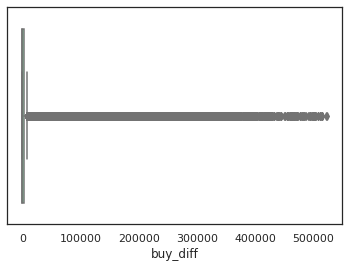

In [60]:
#buy_diff_min.hist()
sns.boxplot(x="buy_diff", data=buy_diff_min, palette='rainbow');


Явно есть выбросы в значениях. Надо посмотреть поближе, с какого момента выбросы. Сократим время до 40 минут.


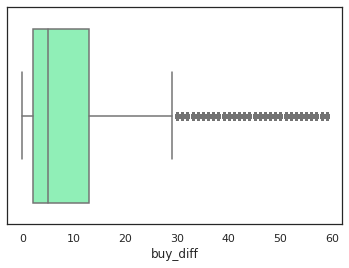

In [61]:
sns.boxplot(x="buy_diff", data=buy_diff_min.query('buy_diff < 60'), palette='rainbow')

Видно, что свыше 30 минут уже начинаются выбросы. Тогда сосредоточимся на 30 минутах. Построим график

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7fb441c310>]],
      dtype=object)

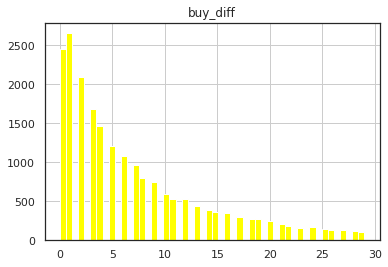

In [62]:
buy_diff_min.query('buy_diff < 30').hist(
                                bins=50,
                                color="#FFFF00")

На графике видно, что большая часть приходится на первые 5 минут, а точнее 0-3 минуты. Потом идет спад. На основе чего можно сделать вывод, что люди заходят на сайт за чем-то конкретным, сразу совершают покупку и уходят с него. 



## Сколько раз покупают за период?

Каждый день куда-то ходить не просто, каждую неделю, возможно, тоже.  Периодом будет месяц. Сколько раз покумают за месяц на сайте? 


In [63]:
orders.head(3)

,date_of_purchase,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


In [64]:
#узнаем время первого заказа
first_purchase = orders.groupby('uid')['date_of_purchase'].min().reset_index()
first_purchase.columns = ['uid', 'date_of_first_purchase']
order_frequency = pd.merge(orders, first_purchase, on='uid')
order_frequency.head(10)

,date_of_purchase,revenue,uid,date_of_first_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:54:00
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00


In [65]:
def diff_month(row):
    date1 = row['date_of_purchase']
    date2 = row['date_of_first_purchase']
    return (date1.year - date2.year) * 12 + date1.month - date2.month

order_frequency['time_diff'] = order_frequency.apply(diff_month, axis=1)
order_frequency['date_of_first_purchase'] = order_frequency['date_of_first_purchase'].astype('datetime64[M]')
order_frequency.head(10)

,date_of_purchase,revenue,uid,date_of_first_purchase,time_diff
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,0
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,0
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,0
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,0
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,0
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,0


In [66]:
purchases_grouped_by_cohorts = (order_frequency
                                                .groupby(['date_of_first_purchase','time_diff'])
                                                .agg({'date_of_purchase': 'count', 'uid': 'nunique'})
                               )

purchases_grouped_by_cohorts['purchases_per_player'] = purchases_grouped_by_cohorts['date_of_purchase']/purchases_grouped_by_cohorts['uid']
purchases_grouped_by_cohorts = purchases_grouped_by_cohorts.reset_index()
purchases_grouped_by_cohorts.head(10)
#когорты по первой сесси и по месяцам. сколько уникальных пользователей, и сколько они делали заказов.

,date_of_first_purchase,time_diff,date_of_purchase,uid,purchases_per_player
0,2017-06-01,0,2354,2023,1.163618
1,2017-06-01,1,177,61,2.901639
2,2017-06-01,2,174,50,3.480000
3,2017-06-01,3,226,54,4.185185
4,2017-06-01,4,292,88,3.318182
5,2017-06-01,5,218,67,3.253731
6,2017-06-01,6,276,62,4.451613
7,2017-06-01,7,174,47,3.702128
8,2017-06-01,8,212,58,3.655172
9,2017-06-01,9,153,45,3.400000


Сделаем таблицу по кол-ву заказов. И нарисуем для нее тепловую карту. 

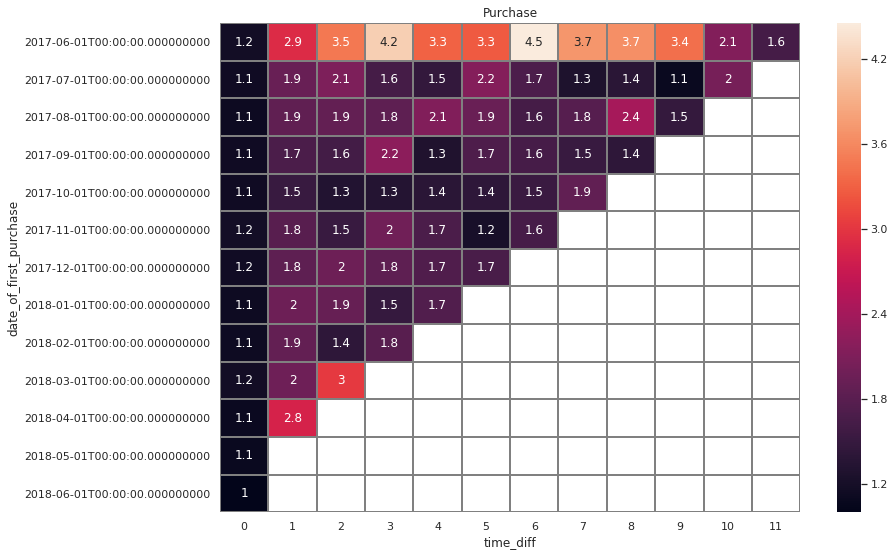

In [67]:
purchase_pivot = purchases_grouped_by_cohorts.pivot_table(index='date_of_first_purchase', 
                                                          columns='time_diff', 
                                                          values='purchases_per_player')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Purchase')
sns.heatmap(purchase_pivot, annot=True, linewidths=1, linecolor='gray');

In [68]:
purchase_pivot.mean().round(2)

time_diff
0     1.13
1     2.02
2     2.03
3     2.03
4     1.84
5     1.91
6     2.10
7     2.03
8     2.22
9     1.99
10    2.09
11    1.62
dtype: float64

In [69]:
purchase_pivot.mean().mean().round(2) #среднее кол-во заказов в месяц на одного клиента

1.92

In [70]:
purchase_count_mean = order_frequency['revenue'].count() / 12 #среднее кол-во заказов на всех в месяц
purchase_count_mean

4201.25

Первая когорта и тут проявляет себя активнее всех прочих. В среднем около трех заказов в месяц она делает. Видно, что заказы оформляются не с первого месяца пользования сервисом, а уже потом. 

Есть выбивающиеся значения среди когорт. Их стоит изучить отдельно, возможно, в этот период была продажа на ряд каких-то события, и люди чаще покупали через сервис. 



## Какой средний чек?

In [71]:
orders_month = orders.copy()
orders_month['date_of_purchase'] = orders['date_of_purchase'].astype('datetime64[M]')
first_orders_month = orders_month.groupby('uid').agg({'date_of_purchase': 'min'}).reset_index()
first_orders_month.columns = ['uid', 'first_purchase_date']

cohort_sizes = first_orders_month.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_purchase_date', 'n_buyers']

first_orders_month_1 = orders_month.merge(first_orders_month, on='uid')
cohorts = (first_orders_month_1
                                    .groupby(['date_of_purchase', 'first_purchase_date'])
                                    .agg({'revenue': 'sum', 'uid': 'count'})
                                    .reset_index()
          )
mean_check = cohorts.merge(cohort_sizes, on='first_purchase_date')
time_diff = mean_check['date_of_purchase'] - mean_check['first_purchase_date']
mean_check['age'] = time_diff / np.timedelta64(1, 'M')
mean_check['age'] = mean_check['age'].round().astype('int')
mean_check['mean_check'] = mean_check['revenue']/mean_check['uid']
mean_check_table = mean_check.pivot_table(index="first_purchase_date", columns="age", values="mean_check")

In [72]:
mean_check_table

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_date,,,,,,,,,,,,
2017-06-01,4.060106,5.547006,5.088161,8.545575,7.084178,6.825321,6.966449,6.761839,5.279009,8.009869,12.038125,6.042093
2017-07-01,5.287123,6.446100,9.992083,6.637596,4.721806,3.659512,3.789508,5.454400,5.345690,11.790000,5.648302,NaN
2017-08-01,4.715479,5.987315,6.281200,6.617901,7.962941,6.265323,5.890000,7.113590,8.702826,5.598478,NaN,NaN
2017-09-01,4.967109,13.171187,8.351056,62.570244,15.430448,15.321835,16.767130,11.206607,7.785574,NaN,NaN,NaN
2017-10-01,4.374738,7.405127,5.127469,5.590246,5.098992,5.071553,4.280233,4.009120,NaN,NaN,NaN,NaN
2017-11-01,4.370717,4.103955,4.474670,6.284976,4.441471,3.726780,4.598235,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.110746,4.226741,20.072772,26.084358,15.948488,14.111048,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.687417,4.438482,6.454969,7.524844,2.711282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.706266,4.576486,3.453735,3.867143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


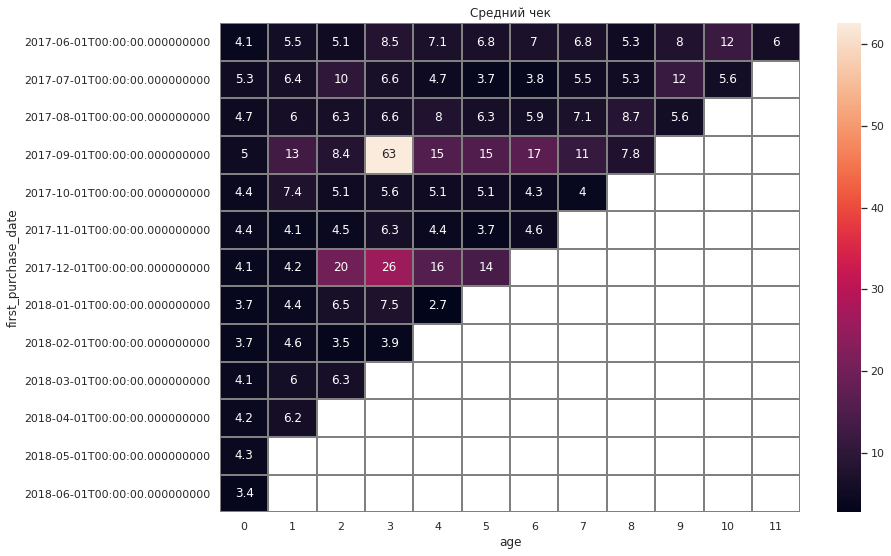

In [73]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Средний чек')
sns.heatmap(mean_check_table, annot=True, linewidths=1, linecolor='gray');

In [74]:
mean_check['mean_check'].mean() #среднее по среднему чеку

7.648921983477595

В среднем люди тратят около 8 тысяч рублей. В сентябре и в декабре, по сравнению с остальными месяцами какая-то большая активность. Это позже стоит изучить отдельно. 



## Сколько денег приносят? (LTV)

 LTV — накопительная выручка когорты в пересчёте на количество людей. LTV считают не из выручки, а из валовой прибыли. Значит, нужно найти валовую прибыль, умножив выручку на маржинальность. Возьмем маржинальность = 0,5. Меньше грустно, больше, пока мало реально. 

In [75]:
first_orders_month = orders_month.groupby('uid').agg({'date_of_purchase': 'min'}).reset_index()
first_orders_month.columns = ['uid', 'first_purchase_date']

cohort_sizes = first_orders_month.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_purchase_date', 'n_buyers']



orders_first_orders_month = orders_month.merge(first_orders_month, on='uid')
cohorts = (orders_first_orders_month
                                    .groupby(['date_of_purchase', 'first_purchase_date'])
                                    .agg({'revenue': 'sum'})
                                    .reset_index()
              )


In [76]:
margin_rate = 0.5
report = cohorts.merge(cohort_sizes, on='first_purchase_date')
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['date_of_purchase'] - report['first_purchase_date']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

report_table = report.pivot_table(index="first_purchase_date",
                columns="age",
                values="ltv",
                aggfunc='mean')
    


<font color='blue'> В целом в проекте предполагалось, что margin rate = 1. </font>

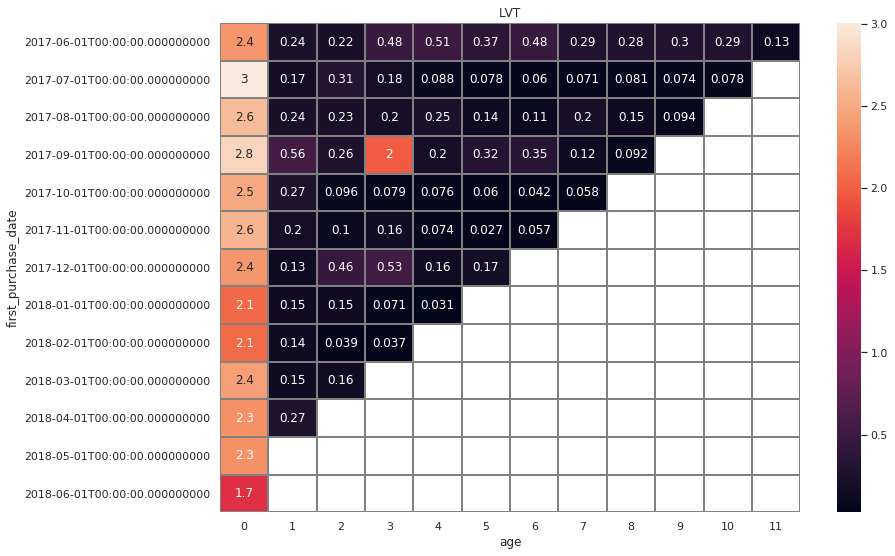

In [77]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LVT')
sns.heatmap(report_table, annot=True, linewidths=1, linecolor='gray');

In [78]:
report['ltv'].mean()

0.5748197460119029

In [79]:
ltv_201701 = report_table.loc['2017-06-01'].sum()
ltv_201701

5.939616905585764

Вновь стабильностью отличается первая когорта. У нее по LTV среди прочих когорт лучний резултат. Вообще, первые когорты проявляют себя лучше, чем последующие. Они более стаблильны



##  Маркетинг
    
Сколько денег потратили? Всего / на каждый источник / по времени
    
Сколько стоило привлечение одного покупателя из каждого источника?
    
На сколько окупились расходы? (ROI)
    




### Сколько денег потратили? Всего / на каждый источник / по времени

Для начала посмотрим, сколько денег всего было потрачено, а так же какая была выручка. Для этого нарисуем круговую диаграмму.

In [80]:
costs_pie = costs.copy()

costs_pie['date'] = costs_pie['date'].values.astype('datetime64[M]') 
costs_pie_grouped = costs_pie.groupby('date').agg({'costs': 'sum'})

In [81]:
orders_grouped = orders_month.groupby('date_of_purchase').agg({'revenue': 'sum'})

In [82]:
data = {'summary': [round(orders_grouped.sum().values[0], 2),round(costs_pie_grouped.sum().values[0], 2)]}
finish_pie = pd.DataFrame(data=data, index=['revenue', 'costs'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


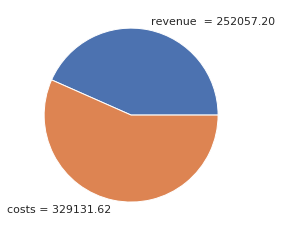

In [83]:
fig1, ax1 = plt.subplots()
ax1.pie(finish_pie, labels=['revenue  = 252057.20', 'costs = 329131.62'])
plt.show()

Суммарная выручка - 252057 рублей.
Суммарные затраты - 329131 рублей.

Пока что затраты превышают выручку. Что не очень хорошо. 

### Сколько денег потратили по времени? 

In [84]:
costs_by_source = (costs
                              .groupby(['source_id', 'date'])['costs']
                              .sum()
                              .reset_index()
                             )
costs_by_source['date'] = costs_by_source['date'].astype('datetime64[M]')
costs_by_source_1 = costs_by_source.groupby(['source_id', 'date'])['costs'].sum().reset_index()


In [85]:
def source_id_name (row):
    source_id = row['source_id']
    if source_id == 1:
        return 'source 1'
    if source_id == 2:
        return 'source 2'
    if source_id == 3:
        return 'source 3'
    if source_id == 4:
        return 'source 4'
    if source_id == 5:
        return 'source 5'
    if source_id == 6:
        return 'source 6'
    if source_id == 7:
        return 'source 7'
    if source_id == 8:
        return 'source 8'
    if source_id == 9:
        return 'source 9'
    if source_id == 10:
        return 'source 10'
    return 'неизвестно'
costs_by_source_1['source_id_name'] = costs_by_source_1.apply(source_id_name, axis=1)

Text(0.5, 1.0, 'Помесячные затраты по каналам')

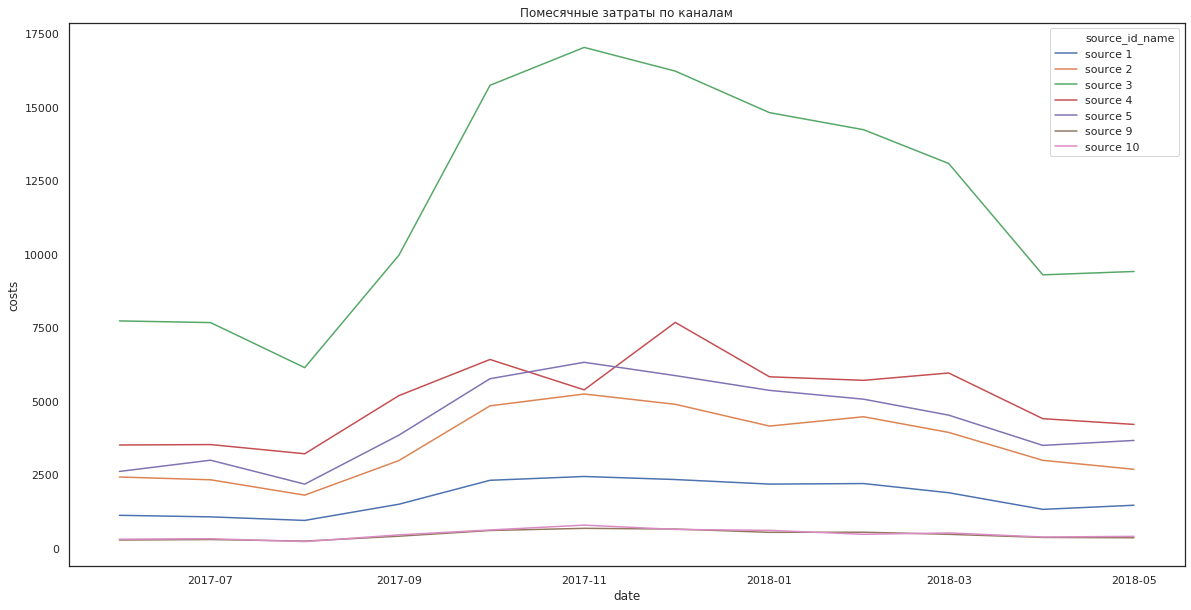

In [86]:
plt.figure(figsize=(20, 10))
(sns.lineplot(
    x='date',
    y='costs',
    hue='source_id_name',
    data=costs_by_source_1,
    markers=True,
    dashes=False).set_title("Помесячные затраты по каналам"))

In [87]:
costs_by_source_group = costs_by_source.groupby('source_id').sum()

(costs_by_source_group.style
                    .bar(subset=['costs'], color='#B0E0E6', vmin=0, width=100)
                    .set_caption("Количество пользователей, зашедших в приложение в месяц"))

,costs
source_id,
1,20833.3
2,42806
3,141322
4,61073.6
5,51757.1
9,5517.49
10,5822.49


С августа 2017 года начали активно вливать в рекламу по всем каналам. Где-то с ноября 2017 стали меньше. Самый вливаемый канал номер 3. На него за год потрачено 141322 рублей 



#### Интересно посмотреть вместе, сколько было затрачено на рекламу, сколько уникальных посетителей привел каждый канал, сколько уникальных покупателей, а так же суммарная выручка. И на сколько по каждому каналу затраты превышают выручку. Это и будут наши основные метрики на данный момент. 

In [88]:
visits_sorted = visits.sort_values(by='session_start') 
#сформируем покупателей по каналам.


In [89]:
costs_source = costs.groupby('source_id').agg({'costs': 'sum'})
#какие были затраты по каналам

In [90]:
first_source_per_user = visits_sorted.groupby('uid').agg({'source id': 'first'})
client_per_source = orders.merge(first_source_per_user, on='uid')
client_per_source = client_per_source.groupby('source id').agg({'uid': 'nunique'})
client_per_source = client_per_source.rename(columns={'uid': 'uid_client_per_source'})
# какая была выручка по каждому из каналов

In [91]:
uid_per_source = visits_sorted.groupby('source id').agg({'uid': 'nunique'})
uid_per_source = uid_per_source.rename(columns={'uid': 'uid_per_source'})
rev_per_source = orders.merge(first_source_per_user, on='uid')
rev_per_source = rev_per_source.groupby('source id').agg({'revenue': 'sum'})
#соберем уникальных пользователей по каналам

In [92]:
rev_uid_costs_per_source = pd.concat([client_per_source, uid_per_source,rev_per_source, costs_source],axis=1).fillna(0)
rev_uid_costs_per_source = rev_uid_costs_per_source.reset_index()

In [93]:
rev_uid_costs_per_source

,index,uid_client_per_source,uid_per_source,revenue,costs
0,1,2899.0,18999,31090.55,20833.27
1,2,3506.0,26245,46923.61,42806.04
2,3,10473.0,74756,54511.24,141321.63
3,4,10296.0,83525,56696.83,61073.60
4,5,6931.0,56974,52624.02,51757.10
5,6,0.0,6,0.00,0.00
6,7,1.0,34,1.22,0.00
7,9,1088.0,9264,5759.40,5517.49
8,10,1329.0,8067,4450.33,5822.49


Третий канал самый затратный, но он при этом не так много клиентов приводит, при том что 1 и 5 каналы обхоядтся нам не так дорого, они выглядят более преспективными. Интересно отметить 7ой канал, в который мы не влияваем никаких средств, но при этом он привел нам одного покупаиеля и 34 посетителя. 

Проиллюстрируем зависимость выручки от вложений

Text(0.5, 1.0, 'Зависимость выручки от затрат')

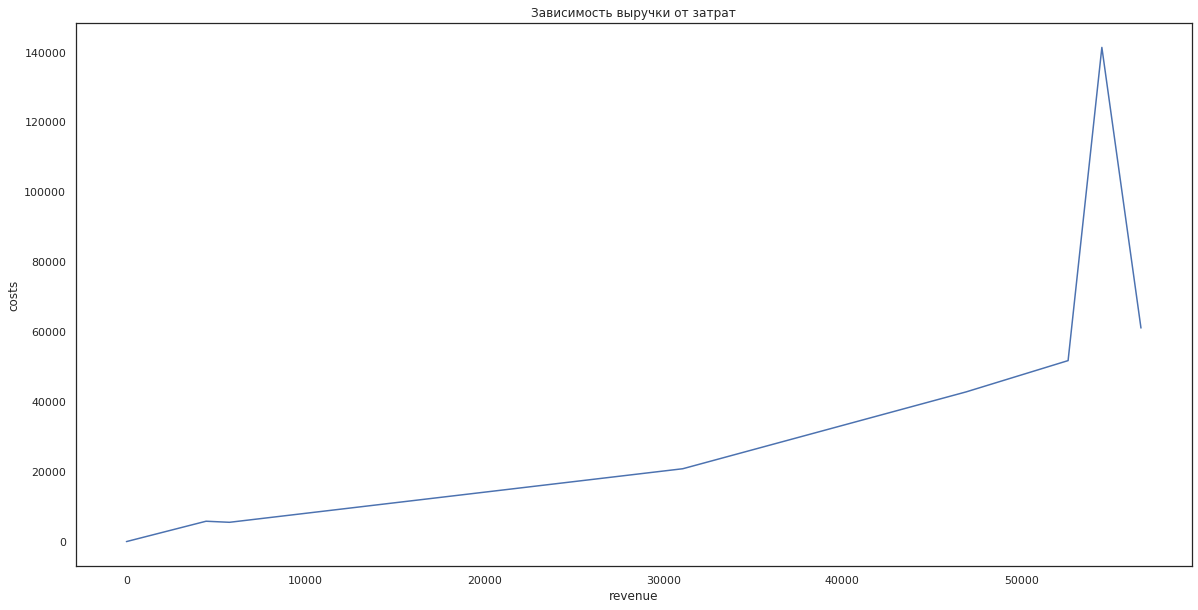

In [94]:
plt.figure(figsize=(20, 10))
(sns.lineplot(
    x='revenue',
    y='costs',
    data=rev_uid_costs_per_source,
    markers=True,
    dashes=False).set_title("Зависимость выручки от затрат"))

В целом, в начале видно, что идет рост, после 50 резкий скачек. Однако, потом резкий спад, после 50 тыс. 

### Сколько стоило привлечение одного покупателя из каждого источника?

In [95]:
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['costs']/rev_uid_costs_per_source['uid_client_per_source']
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['price_for_client'].round(2)
rev_uid_costs_per_source['price_for_client'].sort_values(ascending=False)

2    13.49
1    12.21
4     7.47
0     7.19
3     5.93
7     5.07
8     4.38
6     0.00
5      NaN
Name: price_for_client, dtype: float64

Самые затратные каналы третий и второй. В целом, это видно было и выше на графике. 



### На сколько окупились расходы? (ROI)

Посчитаем накопительный ROI (ROMI)по когортам.

In [96]:
first_orders_month = orders_month.groupby('uid').agg({'date_of_purchase': 'min'}).reset_index()
first_orders_month.columns = ['uid', 'first_purchase_date']

cohort_sizes = first_orders_month.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_purchase_date', 'n_buyers']


orders_first_orders_month = orders_month.merge(first_orders_month, on='uid')
cohorts = (orders_first_orders_month
                                    .groupby(['date_of_purchase', 'first_purchase_date'])
                                    .agg({'revenue': 'sum'})
                                    .reset_index()
              )


margin_rate = 0.5
report = cohorts.merge(cohort_sizes, on='first_purchase_date')
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['date_of_purchase'] - report['first_purchase_date']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

report_table = report.pivot_table(index="first_purchase_date",
                columns="age",
                values="ltv",
                aggfunc='mean')


In [97]:
costs_cac_for_romi = costs.copy()
costs_cac_for_romi['date'] = costs_cac_for_romi['date'].astype('datetime64[M]')
all_costs = costs_cac_for_romi.groupby('date')['costs'].sum().to_frame().reset_index()

report_new = report.merge(all_costs, left_on='first_purchase_date', right_on='date')
report_new['cac'] = report_new['costs']/report_new['n_buyers']
report_new['romi'] = report_new['ltv']/report_new['cac']

romi_pivot = report_new.pivot_table(index='first_purchase_date', columns='age',
                                       values='romi').round(2)

In [98]:
romi_pivot.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_date,,,,,,,,,,,,
2017-06-01,0.27,0.30,0.32,0.37,0.43,0.47,0.52,0.55,0.58,0.61,0.64,0.65
2017-07-01,0.32,0.34,0.37,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,NaN
2017-08-01,0.24,0.26,0.28,0.30,0.32,0.33,0.34,0.36,0.37,0.38,NaN,NaN
2017-09-01,0.30,0.36,0.39,0.60,0.62,0.65,0.69,0.70,0.71,NaN,NaN,NaN
2017-10-01,0.30,0.33,0.34,0.35,0.36,0.37,0.38,0.39,NaN,NaN,NaN,NaN
2017-11-01,0.28,0.30,0.31,0.33,0.34,0.34,0.35,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.27,0.28,0.33,0.39,0.41,0.43,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.21,0.22,0.24,0.25,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.23,0.25,0.25,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# мимни вывод

Изучим,с какого устройства нашим серсвисом пользуются чаще.

In [99]:
visits_by_device = visits.groupby('device').agg({'uid': 'count'})

In [100]:
visits_by_device

,uid
device,
desktop,262567
touch,96833


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


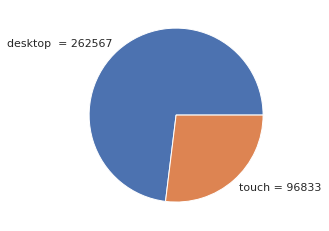

In [101]:
fig1, ax1 = plt.subplots()
ax1.pie(visits_by_device, labels=['desktop  = 262567', 'touch = 96833'])
plt.show()

Люди заходят на сервис чаще с ПК, чем с телефона, стоит об этом передать разработке, возможно, надо наладить что-то в мобильной версии сайте, чтобы с него было удобнее пользоваться сервисом. 

#  Общий вывод

### Продукт

<b>Сколько людей пользуются в день, неделю, месяц?</b>

DAU: 908 пользователей MAU: 5825 пользователя WAU: 23228 пользователей. Судить, много это или мало помог нам анализ дальше. В целом, чтобы окупить затраты, этого не достаточно. Тем более что не все пользователи совершают покупки. 

<b>Сколько сессий в день?</b>

987 сессий. Сервис не предполагает, чтобы на него заходили каждый день несколько раз в день. Следовательно, надо повышать не просто кол-во сессий, а именно кол-во уникальных посетителей и доводить их посещение до покупки. 

<b>Сколько длится одна сессия?</b>

Продолдительность сесси от 0 до 2 минут. Значит пользователи долго на сайте не задерживаются, а почти сразу с него уходят.Как раз это и говорит в пользу того, что пользователь не сидит на сайте долго, а приходит за конкретной покупкой. Возможно, благодаря рекламе. 

<b>Как часто люди возвращаются?</b>

Retention не высокий. На второй месяц 5,5%-8,5%, но дальше он падает до 2,5%-3,5%. Стоить отметить что самый стойкий Retention у первой когорты. Все кто пришли после не так часто возвращаются по сравнению с ними. Чтобы понять, что заставляет возвращаться людей, стоит сосредоточить исследование на первой когорте, посмотреть, по каким каналам рекламы может они переходили на сайт, или какие покупки на нем совершают. 


### Продажи

<b>Когда люди начинают покупать?</b>

Люди совершают свои покупки в первые 2-3 минуты, приходя за чем-то конкретым, а не задерживаясь на сайте, изучая информацию. Есть предположение, что они проходят по запросу с прямой ссылки браузера. Например "билеты на концерт СПЛИН в ноябре". Возможно, в продвижение таких релкамных ссылок по запросу стоит вкладываться больше. Так люди будут преобретать билеты и прочее связанное с мероприятиями чаще через этот сервис. 

<b>Сколько раз покупают за период?</b>

Самое большое колличество покупок за месяц было около 3 у первой когорты. Остальные едва превышают две покупки в месяц. Что опять наводит на мысль об изучении поведения первой когорты. 

<b>Какой средний чек?</b>

В среднем люди тратят около 8 тысяч рублей. Отдельная активность была в сентябре и декабре, где люди тратили больше 8 тыс рублей, стоит проанализироваться, какие события тогда проходили, возможно, это поможет в дальнейшей стратегии по рекламе.  

<b>Сколько денег приносят? (LTV)</b>

Мы посмотрели самую лучшую когорту, она в среднем приносит около 6 тыс рублей за весь период. Остальные, соответсвенно меньше. Кроме небольшого вспелска в сентябре у третьей когорты, положительных тенденций особо не наблюдается. 

### Маркетинг
<b>Сколько денег потратили? Всего / на каждый источник / по времени</b>

Суммарные затраты - 329131 рублей.

1 источник, потратили:	20833.3;
2 источник, потратили:	42806;
3 источник, потратили:	141322;
4 источник, потратили:	61073.6;
5 источник, потратили:	51757.1;
9 источник, потратили:	5517.49;
10 источник, потратили:	5822.49;

3 канал - убыточный для компании. Каналы 1 и 5 - на них стоит обратить внимание, они весьма перспективны и пока не требуют столько вложений, как третий. Каналы 2 3 4 - надо их изучит, как там работает реклама, может ее стоит перенастроить или как-то переделать. 

Начиная августа 2017 года начали активно вливать в рекламу по нескольким каналам. Где-то с ноября 2017 стали меньше значительно скоратили затраты по каналу номер три, и чуть в меньшей степени по остальным каналам. 


<b>Сколько стоило привлечение одного покупателя из каждого источника?</b>

канал 3:	13.49;
канал 2:	12.21;
канал 5:	7.47;
канал 1:	7.19;
канал 4:	5.93;
канал 9:	5.07;
канал 10:	4.38;
канал 7:	0.00;
канал 6:	NaN



<b>На сколько окупились расходы? (ROI)</b>

Расходы не окупились вообще. При маржинальности 0,5 даже нет положительных тенденций. 

Стоит пересмотреть влимаемые в рекламу деньги по каналм, а так же изучит отдельные когорты, чтобы на их примере лучше понять, что же заставляет покупателей возвращаться обратно на сервис и совершать покупки. Бизнес, в состоянии, в котором он есть сейчас - убыточен. 

Так же надо отдельно отметить, что с мобильных устройств гораздо меньше пользователей, чем с ПК, что заставляет задуматься об удобстве моб версии. Возможно, ее надо доработать, чтобы люди могли пользоваться сервисом не только когда под рукой есть ПК. 